In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Properties of LIGO data - Gaussianity

We typically assume that LIGO data are **Gaussian**. Let's take a look at what this means. A Gaussian, also known as a "bell curve" or "normal distribution" is a probability distribution for a random variable $x$ characterized by a mean $\mu$ and width $\sigma$:
$$p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp{\bigg(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\bigg)}$$
Let's plot some of these distributions. Add a new cell below to define a function called `gaussian` using the equation above. We can then use this function to compute $p(x)$ for some values of $x$, $\mu$, and $\sigma$:

In [2]:
def gaussian(x, mu, sigma):
    return 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

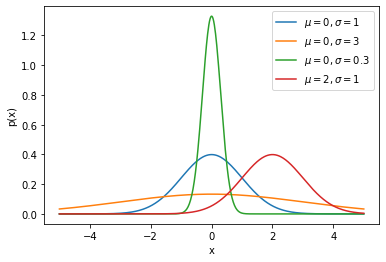

In [3]:
x = np.linspace(-5, 5, 500)
px1 = gaussian(x, 0, 1)
px2 = gaussian(x, 0, 3)
px3 = gaussian(x, 0, 0.3)
px4 = gaussian(x, 2, 1)
plt.plot(x, px1, label=r'$\mu=0, \sigma=1$')
plt.plot(x, px2, label=r'$\mu=0, \sigma=3$')
plt.plot(x, px3, label=r'$\mu=0, \sigma=0.3$')
plt.plot(x, px4, label=r'$\mu=2, \sigma=1$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

What does this distribution actually tell us about the variable $x$? Let's look at an example, where $x$ represents the test scores for a class of 100 students. We generate 100 random test scores as follows:

In [4]:
x = np.random.randn(1000)*7+75

Calculate the mean and standard deviation of $x$, and store the mean in a variable called `mu` and the standard deviation in a variable called `sigma`. How do those values compare to the values multiplying and being added to the `randn` function? What happens if you instead generate 10,000 samples for $x$? Now let's plot a histogram of $x$, where the possible range of values of $x$ is split into bins, and the histogram shows how many of the samples from $x$ are in each bin, and add a plot of our gaussian with mean and sigma given by the values we calculated above to compare:

In [5]:
mu = np.mean(x)
sigma = np.std(x)
print(mu, sigma)

75.47200079595746 7.081771085013442


Text(0.5, 0, 'x')

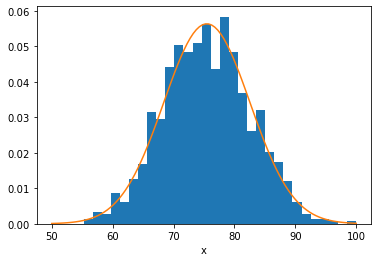

In [6]:
hist, bins, _ = plt.hist(x, bins=30, density=True)
x_vals = np.linspace(50, 100, 100)
plt.plot(x_vals, gaussian(x_vals, mu, sigma))
plt.xlabel('x')

The Gaussian curve matches the histogram of the samples from $x$ very well. This shouldn't be surprising since we know we drew them from a Gaussian distribution. It turns out that LIGO data also follow a Gaussian distribution, but what are the mean and sigma for this distribution? The mean is 0, and the width is the **power spectral density**, or **PSD**. The square root of the PSD is called the amplitude spectral density, or ASD, and it can be used to generate fake LIGO data. Let's download the predicted ASD for advanced LIGO when it reaches design sensitivity, shown below:

## The Amplitude Spectral Density
![PSD](https://dcc.ligo.org/public/0149/T1800044/005/aLIGO_newDesign.pdf)

In [ ]:
#!wget https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt

Text(0, 0.5, 'ASD(f)')

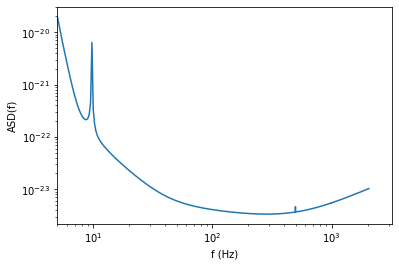

In [7]:
freqs1, asd = np.loadtxt('aLIGODesign.txt', unpack=True)
freqs = np.arange(0, 2048, 0.25)
asd = np.interp(freqs, freqs1, asd)
plt.loglog(freqs, asd)
plt.xlim(5, )
plt.xlabel('f (Hz)')
plt.ylabel('ASD(f)')

This is what the ASD we just downloaded looks like. Now let's generate some Gaussian data which is "colored" by this ASD. Remember that $h(f)$ has both real and imaginary components, so we need to generate two sets of Gaussian data independently.

Text(0, 0.5, 'ASD [$1/\\sqrt{\\mathrm{Hz}}$]')

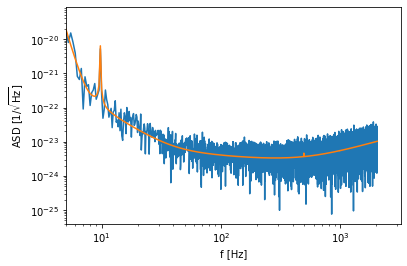

In [8]:
hf = asd*(np.random.randn(len(asd)) + 1j*np.random.randn(len(asd)))
plt.loglog(freqs, abs(hf))
plt.loglog(freqs, asd)
plt.xlim(5, )
plt.xlabel('f [Hz]')
plt.ylabel(r'ASD [$1/\sqrt{\mathrm{Hz}}$]')

Let's check how this relates to the PSD that we previously learned to calculate by taking the inverse Fourier transform of the frequency series we just calculated. First, what are the times corresponding to this frequency series? Remember that the duration is given by $duration = 1/\Delta f$, and $\Delta t = 1/(2f_{\max})$.

In [ ]:
df = freqs[1]-freqs[0]
duration = 1/df
delta_t = 1/(2*freqs[-1])
print(duration, delta_t)
times = np.arange(0, duration, delta_t)

Now let's take the inverse Fourier transform and plot the resulting timeseries data:

In [ ]:
from gwpy.frequencyseries import FrequencySeries
hf_gwpy = FrequencySeries(hf, frequencies=freqs)
ht_gwpy = hf_gwpy.ifft()
ht_gwpy.plot()
plt.ylabel('h(t)')
print(ht_gwpy.times, times)

We can now calculate the PSD from the timeseries plotted above using `gwpy` as before:

In [ ]:
psd_calc = ht_gwpy.psd(fftlength=4, method='median')
plt.loglog(freqs, psd_calc, label='calculated')
plt.loglog(freqs, asd**2, label='design')
plt.legend()

The PSD we used to "color" the data in orange lies right in the middle of the PSD calculated from the simulated data, and the simulated data looks a lot like the real data we used to compute the PSD in the previous notebook! 

### Challenge

Now let's look at one final test of Gaussianity. Let's make a histogram of the data `hf` and fit it with a Gaussian like we did for our test set $x$ above. Calculate `mu` and `sigma` as before. You first need to whiten the **whiten** the data by dividing it by the ASD so all the frequencies can be seen on the same scale. You can do this for either the real part of the simualted data or the imaginary part.

In [ ]:
whitened_data_real = np.real(hf/asd)
mu = np.mean(whitened_data_real)
sigma = np.std(whitened_data_real)
hist, bins, _ = plt.hist(whitened_data_real, bins=30, density=True)
plt.plot(bins, gaussian(bins, mu, sigma))